In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sb
from matplotlib import pyplot as plt

import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

/Users/Ivory/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
import os
filename=[]
for file in os.listdir("/Users/Ivory/Documents/Kaggle/titanic"): #directory to the file
    if file.endswith(".csv"):
        print file;
df=pd.read_csv('train.csv')

test.csv
train.csv


In [4]:
test=pd.read_csv('test.csv')
test.shape
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Check the survival distribution

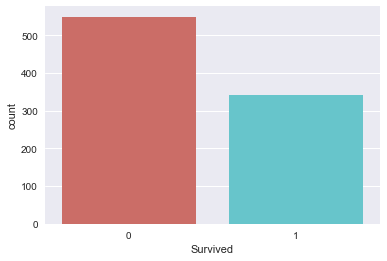

In [5]:
df.describe()
df.shape
sb.countplot(x='Survived',data=df, palette='hls')

# Check the null values in the data

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Survived :  Dependant Variable
pclass   :  Proxy for Economic Status, need to create dummies
Name     :  Passanger Name (can produce word cloud)
sex	     :  Need to create gender dummy
Age      :  Need to fill in null values (will examine later)	
sibsp	 :  # of siblings / spouses aboard the Titanic	
parch	 :  # of parents / children aboard the Titanic	
ticket	 :  Ticket number
fare	 :  determine where they are sitted class, and econ status (see if there is correlation)
cabin	 :  determine where they are sitted but many nulls, I might consider dropping it.
embarked :	C = Cherbourg, Q = Queenstown, S = Southampton, determine how they are sitted, where they are boarded.
            need to create dummies.

In [7]:
#gender dummy
#w.female.replace(['male', 'female'], [1, 0], inplace=True)

df['Cabin_Specified'] = np.where((pd.isnull(df['Cabin'])), 0, 1) 
df['Cabin_Class']= np.where((pd.isnull(df['Cabin'])), 'Unknown', df['Cabin'].astype(str).str[0]) 

Let's look at how passenger age is related to their class as a passenger on the boat.
Pclass = 1 consists of older passanger, pclass= 2 has slightly younger and pclass has the youngest passanger on average.

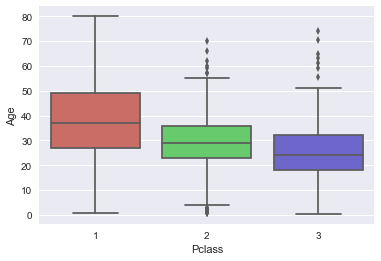

In [8]:
sb.boxplot(x='Pclass', y='Age', data=df, palette='hls')

I am going to fill null values in age with the average age of p_class that they belong to.

In [9]:
df.groupby(['Pclass']).mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

# Create function to fill in null values in age using average age in each pclass

In [10]:
def age_approx(col):
    age= col[0]
    pclass= col[1]
    
    if pd.isnull(age):

        if pclass == 1:
            return 38
        elif pclass == 2:
            return 30
        else:
            return 25
    else:
        return age

In [11]:
df['Age_new'] = df[['Age', 'Pclass']].apply(age_approx, axis=1)
df.isnull().sum()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Specified,Cabin_Class,Age_new
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Unknown,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Unknown,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Unknown,35.0


# Create dummies and select variables to put into model

In [12]:
df['Male']=pd.get_dummies(df['Sex']).male
dummpy_pclass = pd.get_dummies(df['Pclass'], prefix='Pclass')
dummpy_embarked = pd.get_dummies(df['Pclass'], prefix='Embarked')
cols_to_keep = ['Survived', 'Male', 'Age_new','SibSp','Parch','Fare']
train_df = df[cols_to_keep].join(dummpy_pclass.ix[:, 'Pclass_2':]).join(dummpy_embarked.ix[:, 'Embarked_2':])
train_df=train_df.dropna()
train_df.isnull().sum()
train_df.head()

,Survived,Male,Age_new,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_2,Embarked_3
0,0,1,22.0,1,0,7.2500,0,1,0,1
1,1,0,38.0,1,0,71.2833,0,0,0,0
2,1,0,26.0,0,0,7.9250,0,1,0,1
3,1,0,35.0,1,0,53.1000,0,0,0,0
4,0,1,35.0,0,0,8.0500,0,1,0,1


# Check again to make sure there is no null values in training data

In [13]:
train_df.isnull().sum()

Survived      0
Male          0
Age_new       0
SibSp         0
Parch         0
Fare          0
Pclass_2      0
Pclass_3      0
Embarked_2    0
Embarked_3    0
dtype: int64

# Check the correlation among the dependent/ independent variables

,Survived,Male,Age_new,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_2,Embarked_3
Survived,1.000000,-0.543351,-0.050156,-0.035322,0.081629,0.257307,0.093349,-0.322308,0.093349,-0.322308
Male,-0.543351,1.000000,0.080281,-0.114631,-0.245489,-0.182333,-0.064746,0.137143,-0.064746,0.137143
Age_new,-0.050156,0.080281,1.000000,-0.243549,-0.175264,0.121044,0.023949,-0.349323,0.023949,-0.349323
SibSp,-0.035322,-0.114631,-0.243549,1.000000,0.414838,0.159651,-0.055932,0.092548,-0.055932,0.092548
Parch,0.081629,-0.245489,-0.175264,0.414838,1.000000,0.216225,-0.000734,0.015790,-0.000734,0.015790
Fare,0.257307,-0.182333,0.121044,0.159651,0.216225,1.000000,-0.118557,-0.413333,-0.118557,-0.413333
Pclass_2,0.093349,-0.064746,0.023949,-0.055932,-0.000734,-0.118557,1.000000,-0.565210,1.000000,-0.565210
Pclass_3,-0.322308,0.137143,-0.349323,0.092548,0.015790,-0.413333,-0.565210,1.000000,-0.565210,1.000000
Embarked_2,0.093349,-0.064746,0.023949,-0.055932,-0.000734,-0.118557,1.000000,-0.565210,1.000000,-0.565210
Embarked_3,-0.322308,0.137143,-0.349323,0.092548,0.015790,-0.413333,-0.565210,1.000000,-0.565210,1.000000


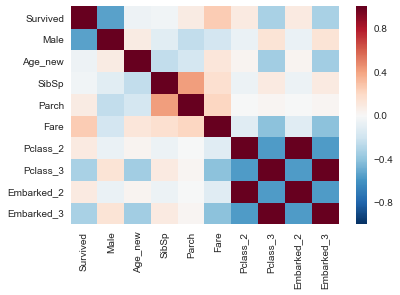

In [14]:
sb.heatmap(train_df.corr())  
train_df.corr()

# Setting dependent variable y and independent variables X

In [15]:
X = train_df.ix[:,(1,2,3,4,5,6,7,8,9)].values
y = train_df.ix[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [16]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[141,  24],
       [ 34,  69]])

In [17]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.85      0.83       165
          1       0.74      0.67      0.70       103

avg / total       0.78      0.78      0.78       268



Precision: Out of all that are being classified as 0, Percentage of them are actually zero?
true position/ (true positive + false positive)

Recall: Out of all that are actually 0, how many of them are classified as 0?
true positive/ (true positive + false negative)

F1 = 2 x (precision x recall)/(precision + recall)

# Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None)

In [19]:
y_pred_naive = clf.predict(X_test)
print(classification_report(y_test, y_pred_naive))

             precision    recall  f1-score   support

          0       0.79      0.72      0.75       165
          1       0.61      0.69      0.65       103

avg / total       0.72      0.71      0.71       268



This performs slight worse than logit model.

# SVM Classifier

In [ ]:
from sklearn import svm
C = 1.0  # SVM regularization parameter
 
# SVC with linear kernel
svc = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
# LinearSVC (linear kernel)
lin_svc = svm.LinearSVC(C=C).fit(X_train, y_train)
# SVC with RBF kernel
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train, y_train)
# SVC with polynomial (degree 3) kernel
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train)

In [ ]:

h = .02  # step size in the mesh
 
# create a mesh to plot in
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
# title for the plots
titles = ['SVC with linear kernel','LinearSVC (linear kernel)','SVC with RBF kernel','SVC with polynomial (degree 3) kernel']
 
 
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
 
# Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(()) 
    plt.yticks(())
    plt.title(titles[i])
 
plt.show()

In [71]:
#df['Cabin'].astype(str).str[0:]

In [105]:
pd.value_counts(df['Pclass'].values, sort=False)

1    216
2    184
3    491
dtype: int64

In [103]:
df.groupby(['Survived']).sum()
df.groupby(['Survived', 'Sex']).size()
df.groupby(['Survived']).mean()
df.groupby(['Cabin_Class','Pclass']).mean()
df.groupby(['Cabin_Class','Pclass','Survived']).count()
df_sub=df[['Cabin_Class','Pclass','Survived']]
df_sub.groupby(['Cabin_Class','Pclass','Survived']).count()
df.groupby(['Survived','Pclass','Embarked']).count()



PassengerId  Name  Sex  Age  SibSp  Parch  Ticket  \
Survived Pclass Embarked                                                      
0        1      C                  26    26   26   21     26     26      26   
                Q                   1     1    1    1      1      1       1   
                S                  53    53   53   42     53     53      53   
         2      C                   8     8    8    7      8      8       8   
                Q                   1     1    1    1      1      1       1   
                S                  88    88   88   82     88     88      88   
         3      C                  41    41   41   23     41     41      41   
                Q                  45    45   45   18     45     45      45   
                S                 286   286  286  229    286    286     286   
1        1      C                  59    59   59   53     59     59      59   
                Q                   1     1    1    1      1      1       1   
                S                  74    74   74   66     74     74      74   
         2      C                   9     9    9    8      9      9       9   
                Q                   2     2    2    1      2      2       2   
                S                  76    76   76   74     76     76      76   
         3      C                  25    25   25   18     25     25      25   
                Q                  27    27   27    6     27     27      27   
                S                  67    67   67   61     67     67      67   

                          Fare  Cabin  Male  Cabin_specified  Cabin_Specified  \
Survived Pclass Embarked                                                        
0        1      C           26     16    26               26               26   
                Q            1      1     1                1                1   
                S           53     42    53               53               53   
         2      C            8      1     8                8                8   
                Q            1      0     1                1                1   
                S           88      2    88               88               88   
         3      C           41      0    41               41               41   
                Q           45      1    45               45               45   
                S          286      5   286              286              286   
1        1      C           59     50    59               59               59   
                Q            1      1     1                1                1   
                S           74     64    74               74               74   
         2      C            9      1     9                9                9   
                Q            2      1     2                2                2   
                S           76     11    76               76               76   
         3      C           25      1    25               25               25   
                Q           27      0    27               27               27   
                S           67      5    67               67               67   

                          Cabin_Class  
Survived Pclass Embarked               
0        1      C                  26  
                Q                   1  
                S                  53  
         2      C                   8  
                Q                   1  
                S                  88  
         3      C                  41  
                Q                  45  
                S                 286  
1        1      C                  59  
                Q                   1  
                S                  74  
         2      C                   9  
                Q                   2  
                S                  76  
         3      C                  25  
                Q                  27  
                S                  67

(array([ 549.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  342.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

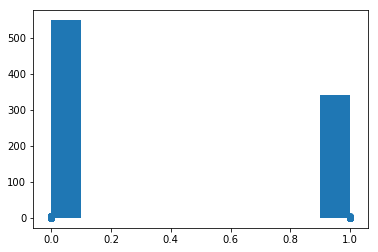

In [110]:
%matplotlib inline
plt.scatter(df.Survived,df.Parch)
plt.hist(df.Survived)

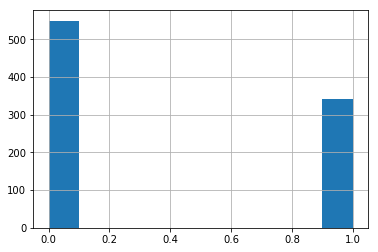

In [111]:
df.Survived.hist()
#df.corr()

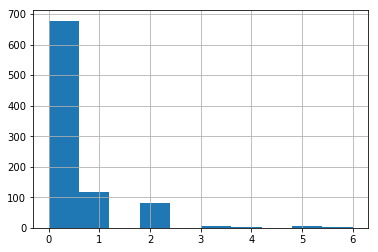

In [28]:
df.Parch.hist()

In [6]:
s = pd.Series(list('abca'))
pd.get_dummies(s)


,a,b,c
0,1,0,0
1,0,1,0
2,0,0,1
3,1,0,0


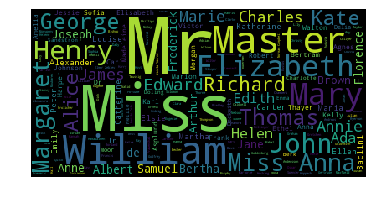

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud_name_survived = WordCloud().generate(' '.join(df[df.Survived == 1]['Name']))
#wordcloud_gen = WordCloud().generate(name)
plt.imshow(wordcloud_name_survived)
plt.axis('off')
plt.show()

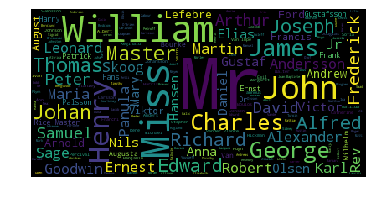

In [30]:
wordcloud_name_nonsurvived = WordCloud().generate(' '.join(df[df.Survived == 0]['Name']))
#wordcloud_gen = WordCloud().generate(name)
plt.imshow(wordcloud_name_nonsurvived)
plt.axis('off')
plt.show()